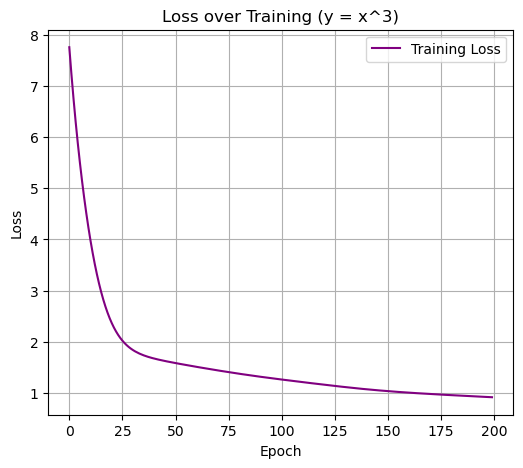

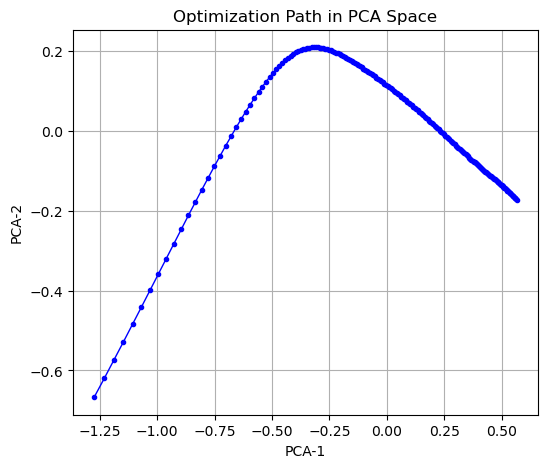

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


x = torch.linspace(-2, 2, 200).unsqueeze(1)
y = x ** 3


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

epochs = 200
losses = []
weights_collected = []


for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

   
    losses.append(loss.item())

    
    weights = []
    for p in model.parameters():
        weights.append(p.detach().numpy().flatten())
    weights_collected.append(np.concatenate(weights))


plt.figure(figsize=(6,5))
plt.plot(range(epochs), losses, label="Training Loss", color="purple")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Training (y = x^3)")
plt.legend()
plt.grid(True)
plt.show()


weights_collected = np.array(weights_collected)
pca = PCA(n_components=2)
weights_2d = pca.fit_transform(weights_collected)

plt.figure(figsize=(6,5))
plt.plot(weights_2d[:,0], weights_2d[:,1], marker="o", markersize=3, linewidth=1, color="blue")
plt.title("Optimization Path in PCA Space")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)
plt.show()


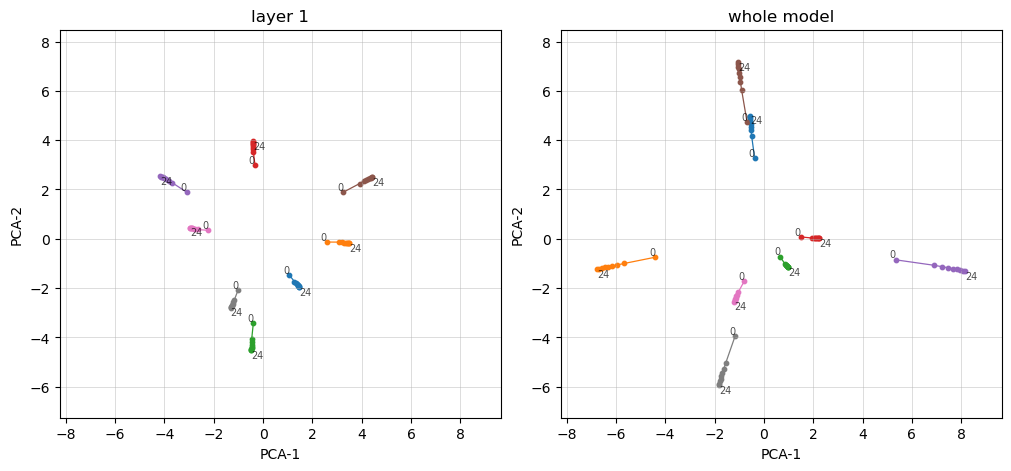

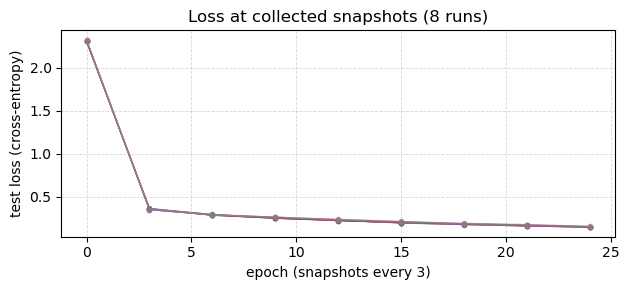

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from math import ceil


epochs = 24
collect_every = 3
n_runs = 8
lr = 0.01
batch_size = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
seeds = [11, 23, 37, 41, 53, 67, 79, 89]  # one per run for reproducibility


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)


class SimpleDNN(nn.Module):
    def __init__(self):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)   # Layer 1
        self.fc2 = nn.Linear(128, 64)      # Layer 2
        self.fc3 = nn.Linear(64, 10)       # Output

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def get_weights(model):
    # flatten all params
    arrs = [p.detach().cpu().numpy().ravel() for p in model.parameters()]
    return np.concatenate(arrs)

def get_layer1_weights(model):
    w = model.fc1.weight.detach().cpu().numpy().ravel()
    b = model.fc1.bias.detach().cpu().numpy().ravel()
    return np.concatenate([w, b])

@torch.no_grad()
def eval_loss(model, loader, criterion):
    model.eval()
    tot, n = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        tot += loss.item() * y.size(0)
        n += y.size(0)
    return tot / n


all_runs_layer1, all_runs_whole = [], []
all_runs_losses = []  # (per snapshot)
criterion = nn.CrossEntropyLoss()

for run in range(n_runs):
    torch.manual_seed(seeds[run])
    np.random.seed(seeds[run])

    model = SimpleDNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    layer1_snapshots, whole_snapshots, loss_snapshots = [], [], []

    
    layer1_snapshots.append(get_layer1_weights(model))
    whole_snapshots.append(get_weights(model))
    loss_snapshots.append(eval_loss(model, testloader, criterion))

    for epoch in range(1, epochs + 1):
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()

        if epoch % collect_every == 0:
            layer1_snapshots.append(get_layer1_weights(model))
            whole_snapshots.append(get_weights(model))
            loss_snapshots.append(eval_loss(model, testloader, criterion))

    all_runs_layer1.append(np.array(layer1_snapshots))
    all_runs_whole.append(np.array(whole_snapshots))
    all_runs_losses.append(np.array(loss_snapshots))


def apply_pca(list_of_runs):
    stacked = np.vstack(list_of_runs)             
    reducer = PCA(n_components=2).fit(stacked)
    out, start = [], 0
    for run in list_of_runs:
        n = run.shape[0]
        out.append(reducer.transform(run))
        start += n
    return out

reduced_layer1 = apply_pca(all_runs_layer1)
reduced_whole  = apply_pca(all_runs_whole)


def global_limits(list_of_runs_a, list_of_runs_b, margin=0.1):
    all_a = np.vstack(list_of_runs_a)
    all_b = np.vstack(list_of_runs_b)
    both = np.vstack([all_a, all_b])
    xmin, ymin = both.min(axis=0)
    xmax, ymax = both.max(axis=0)
    
    dx, dy = xmax - xmin, ymax - ymin
    return (xmin - margin*dx, xmax + margin*dx,
            ymin - margin*dy, ymax + margin*dy)

x0, x1, y0, y1 = global_limits(reduced_layer1, reduced_whole)

colors = plt.cm.tab10.colors  

fig, axes = plt.subplots(1, 2, figsize=(10, 4.6), constrained_layout=True)
titles = ["layer 1", "whole model"]
for ax, reduced, title in zip(axes, [reduced_layer1, reduced_whole], titles):
    for i, coords in enumerate(reduced):
        xs, ys = coords[:, 0], coords[:, 1]
        ax.plot(xs, ys, "-", lw=0.9, color=colors[i % len(colors)])
        ax.scatter(xs, ys, s=10, color=colors[i % len(colors)])
        
        ax.text(xs[0],  ys[0],  "0", fontsize=7, ha="right", va="bottom", alpha=0.7)
        ax.text(xs[-1], ys[-1], f"{collect_every* (len(xs)-1)}", fontsize=7, ha="left", va="top", alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("PCA-1")
    ax.set_ylabel("PCA-2")
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.grid(True, linestyle="-", linewidth=0.6, alpha=0.5)

plt.show()


plt.figure(figsize=(6.4, 3.0))
steps = [k*collect_every for k in range(all_runs_losses[0].shape[0])]
for i, losses in enumerate(all_runs_losses):
    plt.plot(steps, losses, marker="o", ms=3, lw=0.9, color=colors[i % len(colors)], alpha=0.9)
plt.xlabel("epoch (snapshots every 3)")
plt.ylabel("test loss (cross-entropy)")
plt.title("Loss at collected snapshots (8 runs)")
plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
plt.tight_layout()
plt.show()


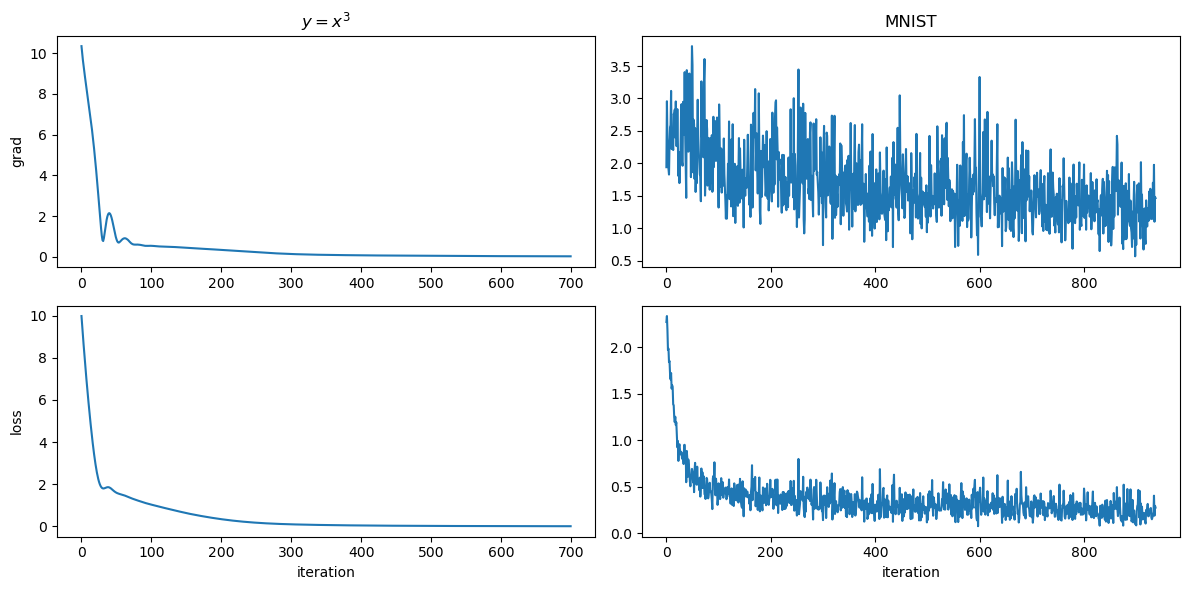

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


x = torch.linspace(-2, 2, 200).view(-1, 1)
y = x ** 3

model_func = nn.Sequential(
    nn.Linear(1, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_func.parameters(), lr=0.01)

losses_func = []
grad_norms_func = []

num_epochs = 700
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model_func(x)
    loss = criterion(outputs, y)
    loss.backward()

   
    grad_all = 0.0
    for p in model_func.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
            grad_all += grad
    grad_norm = grad_all ** 0.5
    grad_norms_func.append(grad_norm)

    losses_func.append(loss.item())
    optimizer.step()



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model_mnist = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mnist.parameters(), lr=0.001)

losses_mnist = []
grad_norms_mnist = []

num_iterations = 18000
model_mnist.train()
iter_count = 0

for images, labels in train_loader:
    if iter_count >= num_iterations:
        break
    optimizer.zero_grad()
    outputs = model_mnist(images)
    loss = criterion(outputs, labels)
    loss.backward()

    
    grad_all = 0.0
    for p in model_mnist.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
            grad_all += grad
    grad_norm = grad_all ** 0.5
    grad_norms_mnist.append(grad_norm)

    losses_mnist.append(loss.item())
    optimizer.step()
    iter_count += 1



fig, axes = plt.subplots(2, 2, figsize=(12, 6))


axes[0,0].plot(range(num_epochs), grad_norms_func)
axes[0,0].set_ylabel("grad")
axes[0,0].set_title(r"$y = x^3$")

axes[1,0].plot(range(num_epochs), losses_func)
axes[1,0].set_xlabel("iteration")
axes[1,0].set_ylabel("loss")


axes[0,1].plot(range(len(grad_norms_mnist)), grad_norms_mnist)
axes[0,1].set_title("MNIST")

axes[1,1].plot(range(len(losses_mnist)), losses_mnist)
axes[1,1].set_xlabel("iteration")

plt.tight_layout()
plt.show()



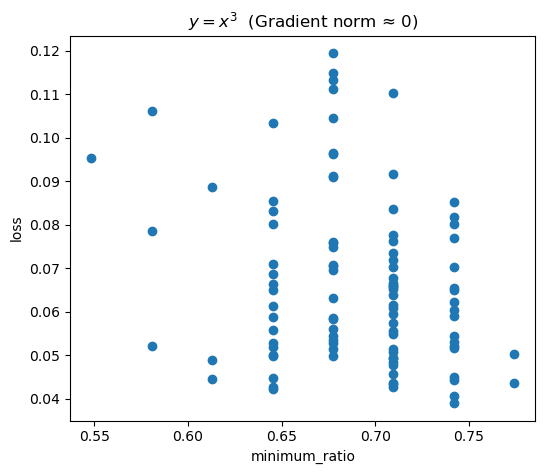

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


x = torch.linspace(-2, 2, 200).view(-1, 1)
y = x ** 3


def get_model():
    return nn.Sequential(
        nn.Linear(1, 10),
        nn.Tanh(),
        nn.Linear(10, 1)
    )

criterion = nn.MSELoss()


def compute_grad_norm(model):
    grad_all = 0.0
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.detach().cpu().numpy() ** 2).sum()
            grad_all += grad
    return grad_all ** 0.5


def compute_hessian_eigs(model, x, y):
    
    loss = criterion(model(x), y)
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    
    grad_vec = torch.cat([g.reshape(-1) for g in grads])
    dim = grad_vec.shape[0]

    H = torch.zeros((dim, dim))
    for i in range(dim):
        grad2 = torch.autograd.grad(grad_vec[i], model.parameters(), retain_graph=True)
        grad2_vec = torch.cat([g.reshape(-1) for g in grad2])
        H[i] = grad2_vec.detach()

    eigvals = torch.linalg.eigvals(H).real.numpy()
    return eigvals


num_trials = 100   
results = []

for trial in range(num_trials):
    model = get_model()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    
    for epoch in range(2000):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        grad_norm = compute_grad_norm(model)
        optimizer.step()

        if grad_norm < 1e-3:  
            break

    
    eigvals = compute_hessian_eigs(model, x, y)
    minimal_ratio = (eigvals > 0).sum() / len(eigvals)

    
    results.append((minimal_ratio, loss.item()))


ratios, losses = zip(*results)


plt.figure(figsize=(6,5))
plt.scatter(ratios, losses)
plt.xlabel("minimum_ratio")
plt.ylabel("loss")
plt.title(r"$y = x^3$  (Gradient norm ≈ 0)")
plt.show()